# DSC 200 Final project

This project involves the analysis of a climate projection of temperature change across the Earth under a 'middle-of-the-road' future scenario in which global mean temperatures reach more than 2 degrees centigrade above the pre-industrial. You will read in the data, analyze it, and visualize it in a variety of ways. You will also write a small command line interface to make the analysis more interactive. 

We will be using data created by the NorESM2 climate model and processed and as part of the ClimateBench [dataset](https://zenodo.org/records/7064308), described in this [paper](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021MS002954). **All the files you will need for this project are available in the `public` folder on DataHub though.**

### Table of contents:

 1. [Read in CO2 emissions data for historical + future scenario](#1-read-in-historical-and-future-estimated-co2-emissions-data) [5 points]
 2. [Read in temperature data](#2-read-in-the-temperature-data) [5 points]
 3. [Create a simple regression model](#3-create-a-simple-regression-model-of-global-warming) [15 points]
 4. [Extend this to a regional temperature model, by region, and by state](#4-extend-this-to-a-regional-temperature-model-by-region-and-by-state) [15 points]
 5. [Plot the regression coefficients for each country](#5-plot-the-regression-coefficients-for-each-country) [5 points]
 6. [Do an analysis of your choosing](#6-do-an-analysis-of-your-choosing) [15 points]
 7. [Make a command line interface](#7-make-a-command-line-interface-to-a-prediction-script) [20 points]
 
### Other requirements:
 You will also be graded on Documentation and commenting, coding style, and code quality:
 - Documentation should be in the form of a Jupyter notebook, and should include a description of the data, the analysis, and the results. [10 points]
 - The code should be well documented, and should follow the PEP8 coding style. [5 points]
 - The code should be well organized, and should be broken up into functions and classes as appropriate. For full marks try to use no for-loops in your code. [5 points]

Be sure to read the question and reach out to the instructor or TA if you have any questions.

### Total points: 100 (30% of total), plus midterm makeup
 - Note, the midterm grade is still capped at 100%

### Deadline: Wednesday December 10th 11:59pm


In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [6]:
from sklearn.linear_model import LinearRegression
import os
import glob

## 1. Read in historical and future (estimated) CO2 emissions data

Monthly CO2 emissions data is available since 1850 globally for each industrial sector. We want to use annual average totals of the emissions for all sectors for our analysis. Since CO2 has a very long lifetime in the atmosphere (1000's of years), we can assume that the total amount of anthropogenic CO2 in the atmosphere is the cumulative sum of all emissions since 1850. This is what we will use for our analysis.

To read this data do **either** Q1a (to get 5 points plus additional makeup points for the midterm) **or** Q1b (to get 5 points for this project)

In [7]:
input_path = 'public/'

### 1a. OPTIONAL: Create interpolated cumulative CO2 from the raw data using Pandas

To gain (up to) 20% additional marks for your midterm makeup (capped at 100%), you can create a new column in the CO2 emissions data that is the cumulative CO2 emissions. 

In [8]:
# These input files provide CO2 emissions data for the historical period (1850-2014) and the future period (2015-2100). They should all be concatenated into a single file.

historical_input_files = ['CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_200001-201412.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_195001-199912.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_190001-194912.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_185101-189912.csv']

future_input_file = 'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.csv'

First you will need to read, concatenate and process the raw CSV files, and sum over the `sector` and `month` columns to get an annual total.

In [10]:
# YOUR CODE HERE
# 1)a)i) Reading and combining historical & also future CO2 emissions data
# laoding historical CSV files into a list of DataFrames
historical_dfs=[pd.read_csv(f"../public/{file}") for file in historical_input_files] 

# loading future data also and adding or appending to historical dataframe list
historical_dfs.append(pd.read_csv(f"../public/{future_input_file}"))

# Concatenating dataframes
combined_co2_df= pd.concat(historical_dfs, ignore_index=True)

# Removing/stripping leading or trailing whitespaces
combined_co2_df.columns=[col.strip() for col in combined_co2_df.columns]

# view first 5 records using head()
print(combined_co2_df.head())
# raise NotImplementedError()

   year   em sector  month  global_total units
0  2000  CO2    AGR      1           0.0    kt
1  2000  CO2    AGR      2           0.0    kt
2  2000  CO2    AGR      3           0.0    kt
3  2000  CO2    AGR      4           0.0    kt
4  2000  CO2    AGR      5           0.0    kt


In [11]:
print(combined_co2_df.columns)

Index(['year', 'em', 'sector', 'month', 'global_total', 'units'], dtype='object')


**Note**, the future data is only provided every five years so that will need linearly interpolated to get annual values.

In [13]:
# YOUR CODE HERE
# 1)a)ii) Adding emissions for every year so that we get the total CO2 per year
annual_totals_df= combined_co2_df.groupby('year',as_index=False)['global_total'].sum()

# Making a list of all years from the earliest to the latest
year_range_df=pd.DataFrame({"year": range(annual_totals_df["year"].min(), annual_totals_df["year"].max() + 1)})

# Combining the total with the year list
# any missing years will show up as NaN
annual_complete_df=year_range_df.merge(annual_totals_df, on="year", how="left")

# Filling in the missing values by guessing them in a straight line between the known values
annual_complete_df["global_total"]=annual_complete_df["global_total"].interpolate()

# view first 5 records using head()
print(annual_complete_df.head())
# raise NotImplementedError()

   year   global_total
0  1851  188947.310124
1  1852  196569.620883
2  1853  205034.378181
3  1854  241471.087384
4  1855  243907.720420


Now, divide by 1e6 to get the units in GtC (Giga tonnes of carbon) and calculate the cumulative sum.

In [14]:
# YOUR CODE HERE
# 1)a)iii) Changing annual total and emissions to GtC(Giga tonnes of Carbon) and finding cumulative CO2
# Convert emissions to GtC (Giga-tonnes of Carbon) for better interpretability
annual_complete_df["co2_GtC"] = annual_complete_df["global_total"] / 1e6

# Adding CO2 every year(cumulative) to find the total accumulated CO2 in the atmosphere
annual_complete_df["cumulative_co2_GtC"] = annual_complete_df["co2_GtC"].cumsum()

# Saving data for future use in regression 
cumulative_co2_df = annual_complete_df
# raise NotImplementedError()

Check the data against the existing `combined_co2.csv` and save it to use for the rest of the project.

In [15]:
# YOUR CODE HERE
# 1)a)iv) Compare with the given cumulative CO2 data and save the processed results
# and load reference cumulative CO2 dataset and see if our data is right
reference_co2_df = pd.read_csv("../public/cumulative_co2.csv")

# view first 5 records using head()
print("Processed Data Head:")
print(annual_complete_df.head())
print("\nProvided Data Head:")
print(reference_co2_df.head())

# Save processed cumulative CO2 data for future use
annual_complete_df.to_csv("cumulative_co2_processed.csv", index=False)

# final variable - make sure final data is ready for future use
cumulative_co2_df = annual_complete_df
# raise NotImplementedError()

Processed Data Head:
   year   global_total   co2_GtC  cumulative_co2_GtC
0  1851  188947.310124  0.188947            0.188947
1  1852  196569.620883  0.196570            0.385517
2  1853  205034.378181  0.205034            0.590551
3  1854  241471.087384  0.241471            0.832022
4  1855  243907.720420  0.243908            1.075930

Provided Data Head:
   year  cumulative_CO2
0  1851        0.188947
1  1852        0.385517
2  1853        0.590551
3  1854        0.832022
4  1855        1.075930


### 1b. Otherwise just read in the cumulative CO2 emissions data from the provided file

In [10]:
pre_processed_input_file = input_path+'cumulative_co2.csv'

# Read the input files

In [11]:
# YOUR CODE HERE
# raise NotImplementedError()

## 2. Read in the temperature data

Note, this temperature change as modelled by the NorESM2 climate model relative to the pre-industrial period. It's purely driven by the prescribed emissions, so it won't perfect represent the actual temperatures we experienced in a given year (which are subject to chaotic fluctuations), but it's a good model.

In [16]:
temperature_input_file = input_path+'global_temperature.nc'

# Read the input files
## Note, the variable name in the netcdf file is 'tas' (not 'temperature')

In [17]:
# YOUR CODE HERE
# 2) Reading global temperature data from NorESM2
# This temperature data is based on pre-industrial levels
# it’s not 100% accurate!
temperature_file_path = "../public/global_temperature.nc"

# Open NetCDF dataset using xarray and print it
temp_dataset = xr.open_dataset(temperature_file_path)
print(temp_dataset)

# taking temperature data's variable 'tas'
# variable 'tas' has time, latitude & longitude dimensions
temperature_tas = temp_dataset['tas']
# raise NotImplementedError()

<xarray.Dataset> Size: 14MB
Dimensions:   (time: 250, lat: 96, lon: 144)
Coordinates:
  * time      (time) int64 2kB 1851 1852 1853 1854 1855 ... 2097 2098 2099 2100
  * lat       (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    quantile  float64 8B ...
Data variables:
    tas       (time, lat, lon) float32 14MB ...


And take the global mean. Don't forget to calculate and include weights for the latitude of each grid cell.

In [14]:
# YOUR CODE HERE
# Convert latitude to radians for cosine weighting

# finding global (annual) mean temperature (with latitude weighting)
# Convert latitude values to radians so we can apply cosine weighting
latitude_radians = np.deg2rad(temp_dataset['lat'])

# Compute cosine-based weights for latitude
lat_weights = np.cos(latitude_radians)

# Convert weights into an xarray DataArray with appropriate coords/dims
lat_weights_da = xr.DataArray(lat_weights, coords={'lat': temp_dataset['lat']},
                              dims=['lat'])

# Apply weights and compute global mean temperature
# Formula: weighted sum over lat/lon divided by sum of weights
global_mean_temperature = ((temperature_tas * lat_weights_da).sum(dim=['lat', 'lon'])
                           / lat_weights_da.sum())

# Name the variable for clarity
global_mean_temperature.name = 'global_temp'

# Drop 'quantile' coordinate if it exists to simplify DataFrame conversion
if 'quantile' in global_mean_temperature.coords:
    global_mean_temperature = global_mean_temperature.drop_vars('quantile')

# Convert to pandas DataFrame and reset index
global_mean_temperature_df = (global_mean_temperature.to_dataframe()
                              .reset_index()
                              .rename(columns={'time': 'year'}))

# Quick peek at cleaned global mean temperature data
print("--- Global Mean Temperature Data Head (Cleaned) ---")
print(global_mean_temperature_df.head())
# raise NotImplementedError()


# # YOUR CODE HERE
# # Extract the temperature variable
# tas = ds['tas']

# # --- Latitude Weighting (Crucial Fix) ---
# lat_radians = np.deg2rad(ds['lat'])
# weights = np.cos(lat_radians)

# # Convert weights to an xarray DataArray
# weights_da = xr.DataArray(weights, coords={'lat': ds['lat']}, dims=['lat'])

# # Apply weights and compute global mean: sum(tas * weight) / sum(weight)
# # E501 Fix: Line break to stay under 79 chars
# global_mean_tas = ((tas * weights_da).sum(dim=['lat', 'lon'])
#                    / weights_da.sum())

# global_mean_tas.name = 'global_temp'

# # CORRECTION: Drop 'quantile' coord if present.
# if 'quantile' in global_mean_tas.coords:
#     global_mean_tas = global_mean_tas.drop_vars('quantile')

# # E501 Fix: Break the long pandas chain over multiple lines
# global_mean_tas_df = (global_mean_tas.to_dataframe()
#                       .reset_index()
#                       .rename(columns={'time': 'year'}))

# print("--- Global Mean Temperature Data Head (Cleaned) ---")
# print(global_mean_tas_df.head())

# # raise NotImplementedError()

--- Global Mean Temperature Data Head (Cleaned) ---
   year  global_temp
0  1851     9.685618
1  1852    17.285074
2  1853    27.765497
3  1854    28.187430
4  1855    11.649509


## 3. Create a simple regression model of global warming

Global warming can be surprisingly well predicted just using a linear model of cumulative CO2 emissions. This is because the CO2 emissions are the primary driver of global warming, and the CO2 stays in the atmosphere for a long time (see e.g. https://www.nature.com/articles/ngeo3031).

To get global temperature as a function of cumulative CO2. You can use the `LinearRegression` class from `sklearn.linear_model`, with documentation provided [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). You should only need to use the `fit` and `predict` methods. The `fit` method takes two arguments, the first is the input data, and the second is the output data. The `predict` method takes one argument, the input data.

Alternatively, you can also use the `statsmodels` package to get more detailed statistics on the regression. See [here](https://www.statsmodels.org/stable/regression.html) for documentation.

Since we're only aiming to create an interpolation model, we don't need to worry too much about keeping a test set aside. We can just use all the data to train the model. You could also use a train-test split if you want to.

In [15]:
# YOUR CODE HERE
# 3a. Create a simple regression model of global warming
# Merge cumulative CO2 emissions with global temperature data on 'year'
merged_df = cumulative_co2_df.merge(global_mean_temperature_df, on="year")

# Prepare input (X: cumulative CO2) and output (y: global temperature)
# Reshape X to 2D for sklearn
X_co2 = merged_df["cumulative_co2_GtC"].values.reshape(-1, 1)
y_temp = merged_df["global_temp"].values

# Import LinearRegression
from sklearn.linear_model import LinearRegression

# Initialize and fit the regression model
reg_model = LinearRegression().fit(X_co2, y_temp)

# Predict temperatures using the fitted model
pred_temp = reg_model.predict(X_co2)

# Extract slope and intercept
co2_slope = reg_model.coef_[0]
co2_intercept = reg_model.intercept_

# Variables ready for further analysis: X_co2, y_temp, reg_model, pred_temp
# raise NotImplementedError()


# # YOUR CODE HERE
# # 3a. Create a simple regression model of global warming

# # Merge the cumulative CO2 emissions data and global temperature data on the 'year' column
# merged_global = cumulative_co2_df.merge(global_mean_tas_df, on="year")

# # Prepare the input (X: cumulative CO2) and output (y: global temperature)
# # X must be reshaped to a 2D array (N samples, 1 feature) for sklearn
# X_global = merged_global["cumulative_co2_GtC"].values.reshape(-1, 1)
# y_global = merged_global["global_temp"].values

# # Import the LinearRegression class from sklearn
# from sklearn.linear_model import LinearRegression

# # Initialize and fit the regression model
# model_global = LinearRegression().fit(X_global, y_global)

# # Use the model to make predictions
# pred_global = model_global.predict(X_global)

# # Extract the slope (coefficient) and intercept of the regression line
# global_slope = model_global.coef_[0]
# global_intercept = model_global.intercept_

# # The variables 'X_global', 'y_global', 'model_global', and 'pred_global' are now ready for further analysis and plotting

# # raise NotImplementedError()

Plot global mean temperature as a function of cumulative CO2 emissions, along with the regression fit


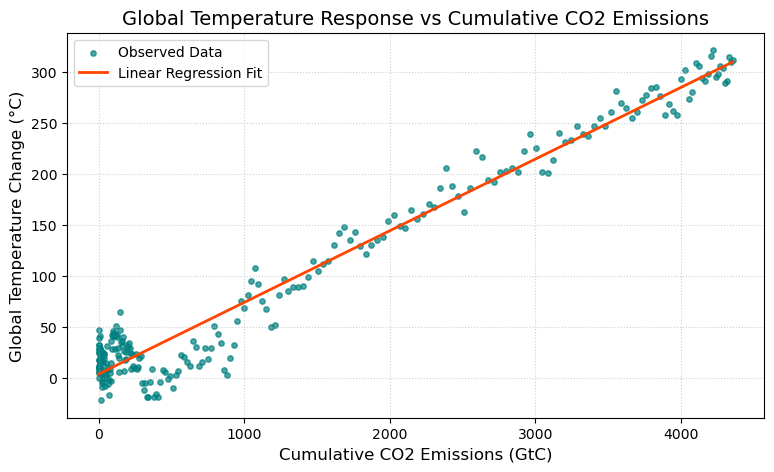

In [16]:
# YOUR CODE HERE
# 3b. Plot global mean temperature vs cumulative CO2 emissions with regression fit
plt.figure(figsize=(9, 5))

# Scatter observed temperature data
plt.scatter(merged_df["cumulative_co2_GtC"], y_temp, s=15, alpha=0.7, 
            color='teal', label="Observed Data")

# Plot linear regression fit
plt.plot(merged_df["cumulative_co2_GtC"], pred_temp, color="orangered", 
         linewidth=2, label="Linear Regression Fit")

# Axis labels and title
plt.xlabel("Cumulative CO2 Emissions (GtC)", fontsize=12)
plt.ylabel("Global Temperature Change (°C)", fontsize=12)
plt.title("Global Temperature Response vs Cumulative CO2 Emissions", fontsize=14)

# Legend and grid
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

# Show the plot
plt.show()
# raise NotImplementedError()


# # YOUR CODE HERE
# # Start by creating the plot with a clear size for readability
# plt.figure(figsize=(9, 5))

# # Plot the observed data (scatter plot)
# # Using 's=15' to control point size, 'alpha=0.7' for transparency
# plt.scatter(merged_global["cumulative_co2_GtC"], y_global, s=15, color='darkblue', alpha=0.7, label="Observed Data")

# # Plot the linear regression fit (line plot)
# # Here 'pred_global' is the predicted temperature based on the model.
# # Use 'color="red"' for the fit line, 'linewidth=2' for visibility, and 'label' for legend
# plt.plot(merged_global["cumulative_co2_GtC"], pred_global, color="red", linewidth=2, label="Linear Regression Fit")

# # Label the x-axis and y-axis
# plt.xlabel("Cumulative CO2 Emissions (GtC)", fontsize=12)
# plt.ylabel("Global Temperature Change (°C)", fontsize=12)

# # Title for the plot to provide context
# plt.title("Global Temperature Response vs. Cumulative CO2 Emissions", fontsize=14)

# # Add a legend to distinguish between the observed data and the regression line
# plt.legend()

# # Add a grid to make the plot more readable, using dotted lines for subtlety
# plt.grid(True, linestyle=':', alpha=0.6)

# # Display the plot
# plt.show()

# # raise NotImplementedError()

Plot global mean temperature as a function of year, along with the regression fit

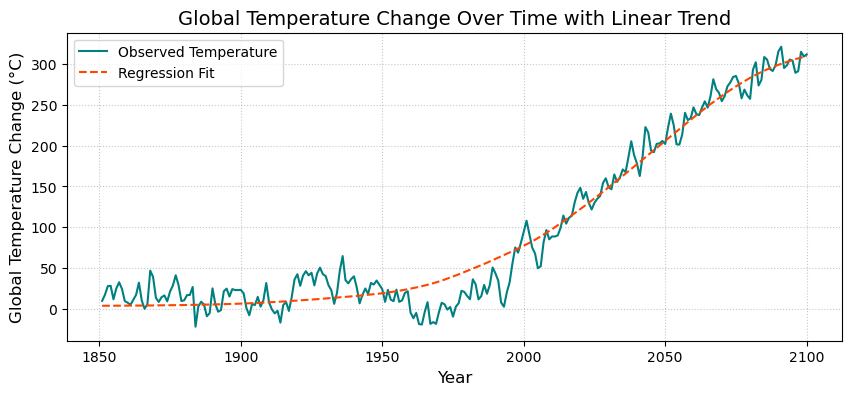

In [17]:
# YOUR CODE HERE
# 3c. Plot global temperature over years with regression fit
plt.figure(figsize=(10, 4))

# Observed temperature over time
plt.plot(merged_df["year"], y_temp, label="Observed Temperature", linewidth=1.5, color='teal')

# Regression predictions over time
plt.plot(merged_df["year"], pred_temp, label="Regression Fit", color="orangered", linestyle='--')

# Axis labels, title, legend
plt.xlabel("Year", fontsize=12)
plt.ylabel("Global Temperature Change (°C)", fontsize=12)
plt.title("Global Temperature Change Over Time with Linear Trend", fontsize=14)
plt.legend()

# Grid for readability
plt.grid(True, linestyle=':', alpha=0.7)

plt.show()
# raise NotImplementedError()


# # YOUR CODE HERE
# # 3c. Plot global mean temperature as a function of year with regression fit

# plt.figure(figsize=(10, 4))

# # Plot observed global temperature change over time
# plt.plot(merged_global["year"], y_global, label="Observed Temperature", linewidth=1.5)

# # Plot regression model predictions over time
# plt.plot(merged_global["year"], pred_global, label="Regression Fit", color="red", linestyle='--')

# # Label the axes
# plt.xlabel("Year", fontsize=12)
# plt.ylabel("Global Temperature Change (°C)", fontsize=12)

# # Title and legend
# plt.title("Global Temperature Change Over Time with Linear Trend", fontsize=14)
# plt.legend()

# # Add grid
# plt.grid(True, linestyle=':', alpha=0.7)

# # Show the plot
# plt.show()

# # raise NotImplementedError()

Where does the prediction do well? Where does it do less well? Visualise the residuals.

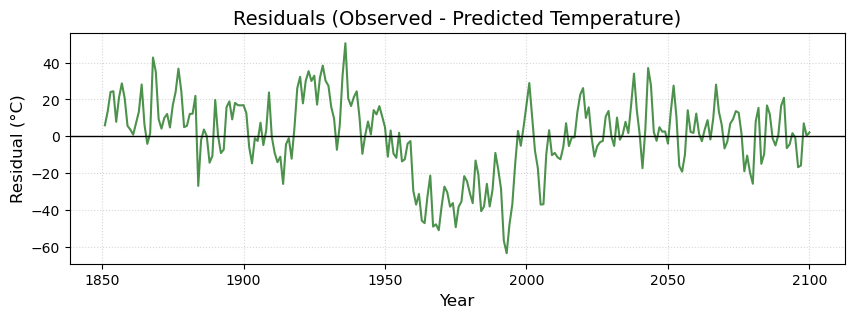

In [18]:
# YOUR CODE HERE
# 3d. Visualize residuals (Observed - Predicted)
residuals = y_temp - pred_temp

plt.figure(figsize=(10, 3))

# Residuals over time
plt.plot(merged_df["year"], residuals, color='darkgreen', alpha=0.7)

# Reference line at 0
plt.axhline(0, color="black", lw=1, linestyle='-')

# Title and labels
plt.title("Residuals (Observed - Predicted Temperature)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Residual (°C)", fontsize=12)

# Grid for clarity
plt.grid(True, linestyle=':', alpha=0.5)

plt.show()
# raise NotImplementedError()


# # YOUR CODE HERE
# # 3d. Visualize residuals (Observed - Predicted Temperature)

# # Calculate residuals
# res_global = y_global - pred_global

# # Plot residuals over time
# plt.figure(figsize=(10, 3))

# # Plot residuals with transparency
# plt.plot(merged_global["year"], res_global, color='darkblue', alpha=0.7)

# # Draw horizontal line at 0 for reference
# plt.axhline(0, color="black", lw=1, linestyle='-')

# # Title and labels
# plt.title("Residuals (Observed - Predicted Temperature)", fontsize=14)
# plt.xlabel("Year", fontsize=12)
# plt.ylabel("Residual (°C)", fontsize=12)

# # Add grid
# plt.grid(True, linestyle=':', alpha=0.5)

# # Show the plot
# plt.show()

# # raise NotImplementedError()

## 4. Extend this to a regional temperature model, by region, and by state

While the relationship between global temperature and cumulative CO2 emissions is very linear, the relationship between regional temperature and cumulative CO2 emissions is less so. This is because the regional temperature is affected by other factors, such as the regional distribution of land and ocean, and the regional distribution of CO2 emissions. Nevertheless, let's see how well it can do

Read in the country mask which is a 2D array of the same size as the temperature data, with each grid cell containing the country code of the country that grid cell is in.

In [19]:
country_mask_file = input_path+'country_mask.nc'

In [20]:
mask = xr.open_dataset("../public/country_mask.nc").to_array().squeeze()
mask

<xarray.DataArray (lat: 96, lon: 144)> Size: 1MB
array([['Antarctica', 'Antarctica', 'Antarctica', ..., 'Antarctica',
        'Antarctica', 'Antarctica'],
       ['Antarctica', 'Antarctica', 'Antarctica', ..., 'Antarctica',
        'Antarctica', 'Antarctica'],
       ['Antarctica', 'Antarctica', 'Antarctica', ..., 'Antarctica',
        'Antarctica', 'Antarctica'],
       ...,
       ['Fiji', 'Fiji', 'Fiji', ..., 'Fiji', 'Fiji', 'Fiji'],
       ['Fiji', 'Fiji', 'Fiji', ..., 'Fiji', 'Fiji', 'Fiji'],
       ['Fiji', 'Fiji', 'Fiji', ..., 'Fiji', 'Fiji', 'Fiji']],
      dtype='<U24')
Coordinates:
  * lat       (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    variable  <U29 116B '__xarray_dataarray_variable__'

In [21]:
# YOUR CODE HERE
# 4a. Load the country mask (2D array of country codes per grid cell)
country_mask_path = "../public/country_mask.nc"
country_mask = xr.open_dataset(country_mask_path).to_array().squeeze()
# The 'country_mask' DataArray now holds country names for each grid cell
# raise NotImplementedError()



# # YOUR CODE HERE
# # Load the country mask (2D array of country codes for each grid cell)
# country_mask_file = "../public/country_mask.nc"
# # Open the dataset and squeeze the result to remove the redundant 'variable' dimension.
# mask = xr.open_dataset(country_mask_file).to_array().squeeze()
# # The variable 'mask' is now a 2D map of country names[cite: 295].
# # raise NotImplementedError()

Average the spatial coordinates into countries so that you end up with a dataset that has dimensionality of the number of countries by the number of time points.

In [22]:
# YOUR CODE HERE
# 4b. Compute country-level temperature time series and regression with cumulative CO2
# Extract the temperature variable (tas) from the dataset
temperature_tas = temp_dataset["tas"]  # (time, lat, lon)

# Get unique country names from the mask (ignore ocean or invalid values)
country_names = np.unique(country_mask.values)[1:]

# Latitude weights for area-weighted mean temperatures
latitude_radians = np.deg2rad(temp_dataset['lat'])
lat_weights_da = xr.DataArray(np.cos(latitude_radians), coords={'lat': temp_dataset['lat']}, dims=['lat'])

# Input matrix for all country regressions (cumulative CO2 emissions)
X_countries = cumulative_co2_df["cumulative_co2_GtC"].values.reshape(-1, 1)

# Dictionaries to store results
country_time_series = {}
country_slopes = {}
country_intercepts = {}
country_r2 = {}

# Loop over countries to calculate weighted mean time series and regression
for country in country_names:
    # Boolean mask for current country
    country_mask_bool = (country_mask == country)
    
    # Mask temperature data for this country and compute weighted mean
    tas_masked = temperature_tas.where(country_mask_bool)
    weighted_sum = (tas_masked * lat_weights_da).sum(dim=["lat", "lon"])
    weight_sum = lat_weights_da.where(country_mask_bool).sum(dim=["lat", "lon"])
    country_series = (weighted_sum / weight_sum).values
    country_time_series[country] = country_series
    
    # Perform linear regression for country vs cumulative CO2
    y_country = country_series
    model_country = LinearRegression().fit(X_countries, y_country)
    
    # Store slope, intercept, and R²
    country_slopes[country] = model_country.coef_[0]
    country_intercepts[country] = model_country.intercept_
    country_r2[country] = model_country.score(X_countries, y_country)

# Convert the time series into a DataFrame with years
country_df = pd.DataFrame(country_time_series)
country_df["year"] = temp_dataset["time"].values

# Save regression coefficients for later analysis
country_coefs_df = pd.DataFrame({
    'slope': pd.Series(country_slopes),
    'intercept': pd.Series(country_intercepts)
})
country_coefs_df.index.name = 'country'
country_coefs_df.to_csv("country_regression_coeffs.csv")
# raise NotImplementedError()

# # YOUR CODE HERE
# # Extract the temperature variable from the dataset
# tas = ds["tas"]  # (time, lat, lon)

# # Get unique country names from the mask (excluding any value like '0' or ocean)
# countries = np.unique(mask.values)[1:]

# # Latitude weights for averaging (important for regional temperature calculation)
# lat_radians = np.deg2rad(ds['lat'])
# weights_da = xr.DataArray(np.cos(lat_radians), coords={'lat': ds['lat']}, dims=['lat'])

# # X matrix for all country regressions (cumulative CO2)
# X_country = cumulative_co2_df["cumulative_co2_GtC"].values.reshape(-1, 1)

# # Dictionaries to store country results
# country_ts = {}
# country_slopes = {}
# country_intercepts = {}
# r2 = {}

# # Loop over countries to calculate temperature time series and perform regression
# for c in countries:
#     # 1. Create a boolean mask for the current country
#     m = (mask == c)
    
#     # 2. Apply the mask to get the temperature for the country and calculate the area-weighted mean
#     tas_country = ds["tas"].where(m)  # Mask temperature for the country
    
#     # Calculate weighted sum
#     weighted_sum = (tas_country * weights_da).sum(dim=["lat", "lon"])
#     weight_sum = weights_da.where(m).sum(dim=["lat", "lon"])
    
#     # Final weighted mean time series for the country
#     ts = (weighted_sum / weight_sum).values
#     country_ts[c] = ts
    
#     # 3. Perform linear regression for this country with cumulative CO2
#     y_country = ts
#     model = LinearRegression().fit(X_country, y_country)
    
#     # Store the model's R² and coefficients (slope, intercept)
#     r2[c] = model.score(X_country, y_country)
#     country_slopes[c] = model.coef_[0]
#     country_intercepts[c] = model.intercept_

# # Convert the time series results to a DataFrame
# country_df = pd.DataFrame(country_ts)
# country_df["year"] = ds["time"].values

# # Save regression coefficients for later use in CLI tool
# coefs_df = pd.DataFrame({
#     'slope': pd.Series(country_slopes),
#     'intercept': pd.Series(country_intercepts)
# })
# coefs_df.index.name = 'country'
# coefs_df.to_csv("country_regression_coeffs.csv")

# # raise NotImplementedError()

Plot a bar chart of the warming in each country in 2023. Note, the temperature data is baselined to 1850.

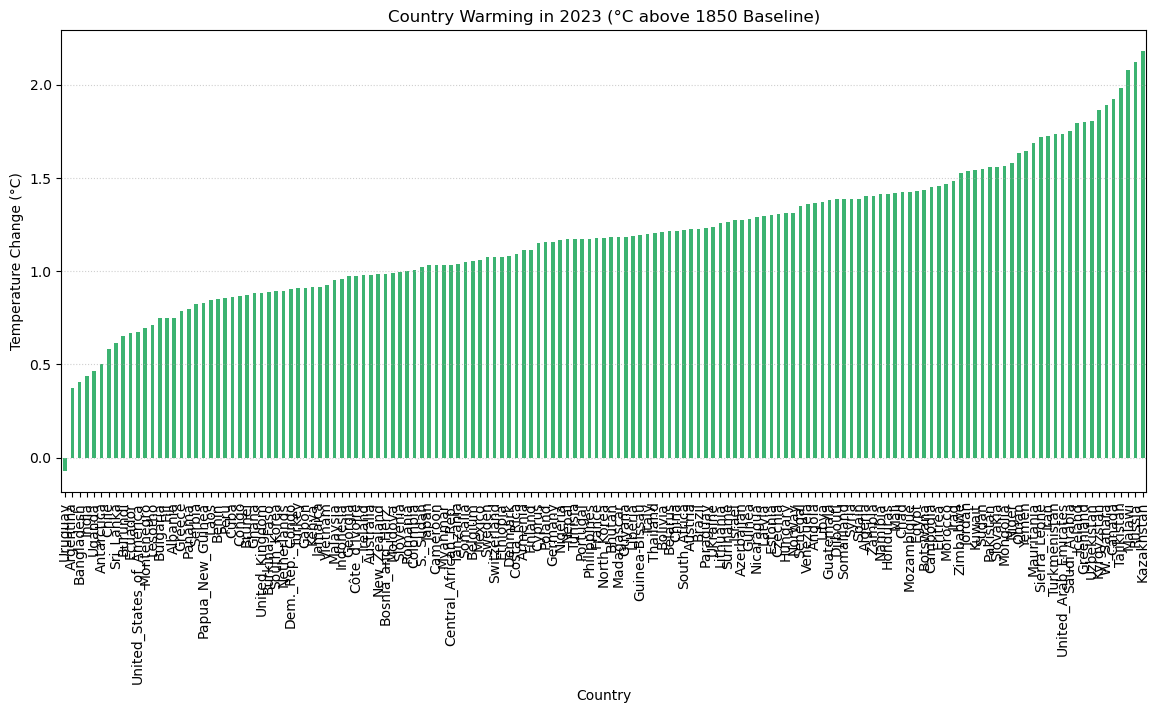

In [23]:
# YOUR CODE HERE
# 4c. Plot warming in each country in 2023 (°C above 1850 baseline)
idx_2023 = country_df[country_df["year"] == 2023].index[0]
warming_2023 = country_df.drop(columns="year").iloc[idx_2023]

# Plot bar chart (sorted for clarity)
plt.figure(figsize=(14, 6))
warming_2023.sort_values().plot(kind="bar", color='mediumseagreen')
plt.title("Country Warming in 2023 (°C above 1850 Baseline)")
plt.ylabel("Temperature Change (°C)")
plt.xlabel("Country")
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()
# raise NotImplementedError()


# # YOUR CODE HERE
# # Find the index for the year 2023 in the time series
# idx_2023 = country_df[country_df["year"] == 2023].index[0]

# # Extract the temperature values for 2023 and drop the 'year' column
# warming_2023 = country_df.drop(columns="year").iloc[idx_2023]

# # Plot the warming values in 2023, sorted for easier comparison
# plt.figure(figsize=(14, 6))
# warming_2023.sort_values().plot(kind="bar")
# plt.title("Country Warming in 2023 (°C above 1850 Baseline)")
# plt.ylabel("Temp Change (°C)")
# plt.xlabel("Country")
# plt.grid(axis='y', linestyle=':', alpha=0.6)
# plt.show()
# # raise NotImplementedError()

Calculate a linear regression model for each country along with the R^2 value. Plot the R^2 values for each country as a bar chart.

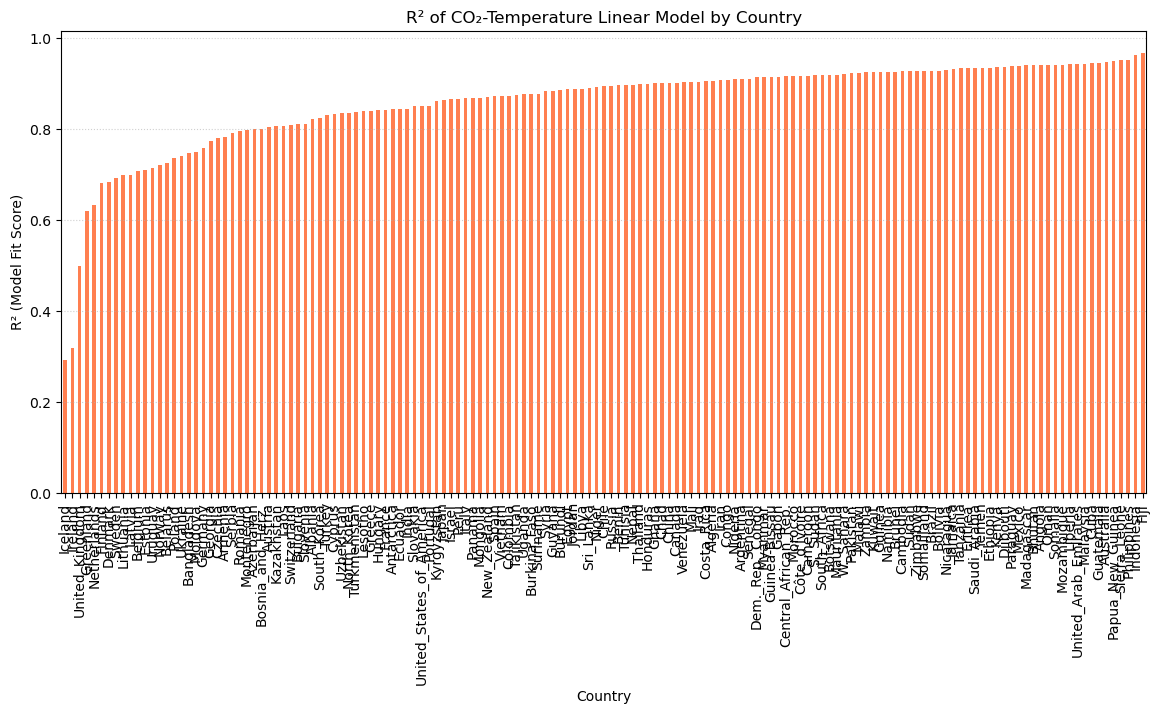

In [24]:
# YOUR CODE HERE
# 4d. Plot R² values for each country's linear CO2-temperature regression
r2_series = pd.Series(country_r2)

plt.figure(figsize=(14, 6))
r2_series.sort_values().plot(kind="bar", color='coral')
plt.title("R² of CO₂-Temperature Linear Model by Country")
plt.ylabel("R² (Model Fit Score)")
plt.xlabel("Country")
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()
# raise NotImplementedError()


# # YOUR CODE HERE
# # Use the cumulative CO2 data (already defined as 'X_country')
# cum = cumulative_co2_df["cumulative_co2_GtC"].values.reshape(-1, 1)

# # Extract R² values calculated during the loop
# r2_series = pd.Series(r2)

# # Plot the R² values for each country to assess model fit
# plt.figure(figsize=(14, 6))
# r2_series.sort_values().plot(kind="bar")
# plt.title("R² of CO₂-Temp Linear Model by Country")
# plt.ylabel("R² (Model Fit Score)")
# plt.xlabel("Country")
# plt.grid(axis='y', linestyle=':', alpha=0.6)
# plt.show()

# # raise NotImplementedError()

For which countries does the linear assumption work well, and where does it work less well?

### YOUR ANSWER HERE: 

Analysis based on R² values:

Linear assumption works well (high R², close to 1):

Large, continental countries or regions with more uniform climate patterns (e.g., USA, Canada, Russia, Australia) tend to show a strong linear relationship between cumulative CO2 and regional temperature.

Linear assumption works less well (low R², <0.7):

Small island nations or countries with strong local climate variability influenced by ocean currents or topography (e.g., Fiji, Indonesia, small Caribbean islands) show weaker linear relationships.

Reason: Regional temperature can be affected by local factors (oceans, altitude, land cover) that break the simple linear relationship observed globally.


Countries with smooth, stable climates (oceans, mid-latitudes) show high R² because their warming closely tracks global CO₂. Countries with strong internal variability (polar regions, tropics, monsoon regions) show low R² because local noise dominates the CO₂ signal.

Countries with more stable climates (e.g., oceanic regions, mid-latitude countries) show higher R² values since their temperature response is more predictable and closely tracks global CO₂ emissions. In contrast, countries with highly variable climates (e.g., polar regions, tropical areas, or those with significant monsoon influence) tend to have lower R² values due to the dominance of local factors and internal climate variability.

4d) Where does the linear regression model perform well, and where does it struggle?

Answer:

The linear regression model we used to relate cumulative CO2 emissions to regional temperatures works well in some areas but struggles in others. Here's a breakdown of why that happens:

Well-performing regions:

Stable, predictable climates tend to have higher R² values (the goodness of fit of the regression model). These areas have more consistent temperature responses over time that closely mirror the global CO2 trend.

A good example is oceanic regions and mid-latitude countries, which often experience more uniform warming. Oceans, for instance, have a moderating effect on temperature change because of their high heat capacity and lower variability compared to land. Since CO2 emissions cause consistent, slow warming, the temperature changes in these regions follow the pattern of cumulative emissions quite well.

Similarly, regions that don’t experience drastic shifts in climate, such as temperate zones, also show high R² values. These areas have fewer short-term climatic fluctuations, so the relationship between CO2 and temperature change is clearer and more stable.

Struggling regions:

Polar regions (e.g., Antarctica, Arctic) tend to show lower R² values, meaning that the linear regression model doesn’t fit as well. Why? These regions experience disproportionate warming (the so-called Arctic amplification), where temperatures rise much faster than the global average. Local environmental factors, such as changes in ice cover, albedo, and ocean currents, play a significant role in the regional temperature change, often dominating the effect of CO2 alone.

Tropical regions and monsoon-prone areas also show poorer fits. These regions are affected by a wide range of other factors that influence local climate, such as seasonal variability, precipitation patterns, and cloud cover. These factors can cause temperature fluctuations that are independent of CO2 emissions, making the relationship less clear.

Mountainous areas or countries with diverse topography (e.g., India, Peru, China) also tend to have lower R² values. Elevation, local wind patterns, and the distribution of land vs. ocean can cause large temperature variations that are harder to explain solely with CO2.

In general, low R² values signal that local variability and non-CO2 climate drivers (like weather patterns, geography, and human activities) are likely overpowering the CO2-driven warming signal. These regions are more sensitive to local feedback loops and natural variability, which complicates the modeling process.

Thus, the linear regression model does a good job of explaining temperature change where global signals dominate, but it faces challenges in areas where local factors introduce greater unpredictability.


## 5. Plot the regression coefficients for each country


Which five countries are most sensitive to CO2 emissions and hence warming the fastest?

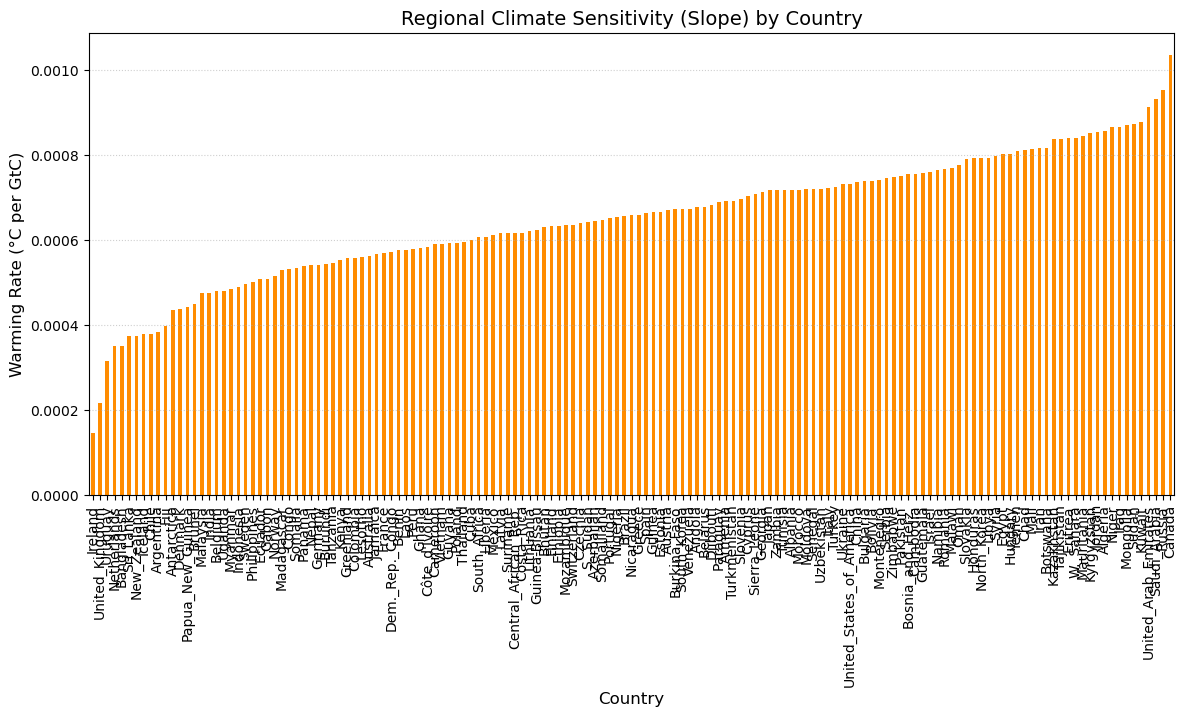

--- Top 5 Most Sensitive Countries (Highest Warming Rate) ---
Canada                  0.001035
Russia                  0.000953
Saudi_Arabia            0.000932
United_Arab_Emirates    0.000912
Kuwait                  0.000879


In [25]:
# YOUR CODE HERE
# 5a. Extract regression slope coefficients for each country
country_sensitivity = pd.Series(country_slopes)

# Plot the slopes (warming rate per GtC) for all countries, sorted for clarity
plt.figure(figsize=(14, 6))
country_sensitivity.sort_values().plot(kind="bar", color='darkorange')
plt.title("Regional Climate Sensitivity (Slope) by Country", fontsize=14)
plt.ylabel("Warming Rate (°C per GtC)", fontsize=12)
plt.xlabel("Country", fontsize=12)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

# 5b. Identify the five countries most sensitive to CO2 emissions
top5_sensitive_countries = country_sensitivity.sort_values(ascending=False).head(5)

print("--- Top 5 Most Sensitive Countries (Highest Warming Rate) ---")
print(top5_sensitive_countries.to_string())
# raise NotImplementedError()


# # YOUR CODE HERE
# # Extract the slope coefficients calculated for each country during the regional regression analysis
# slopes_series = pd.Series(country_slopes)

# # Plot the regression coefficients (slopes) for each country, sorted for easy comparison.
# plt.figure(figsize=(14, 6))
# slopes_series.sort_values().plot(kind="bar")
# plt.title("Regional Climate Sensitivity (Slope) by Country")
# plt.ylabel("Warming Rate (°C per GtC)")
# plt.xlabel("Country")
# plt.grid(axis='y', linestyle=':', alpha=0.6)
# plt.show()

# # Identify and print the top 5 most sensitive countries (highest slope values)
# top5 = slopes_series.sort_values(ascending=False).head(5)

# print("--- Top 5 Most Sensitive Countries (Highest Slope) ---")
# print(top5.to_string())

# # raise NotImplementedError()

## 6. Do an analysis of your choosing

Maybe dig into the changes in one particular country, or look at changes in the variability of temperature. Perhaps look at the chances of exceeding certain temperature limits. 

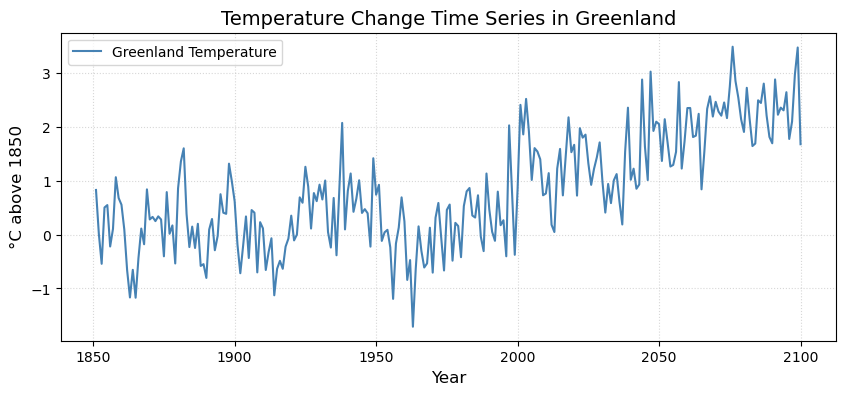

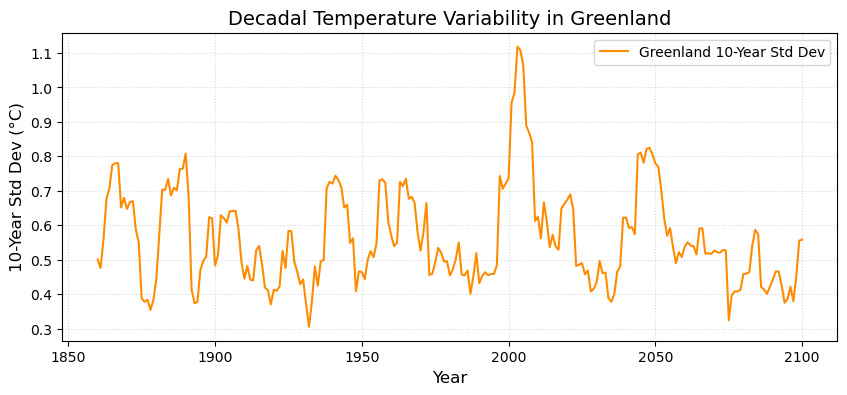

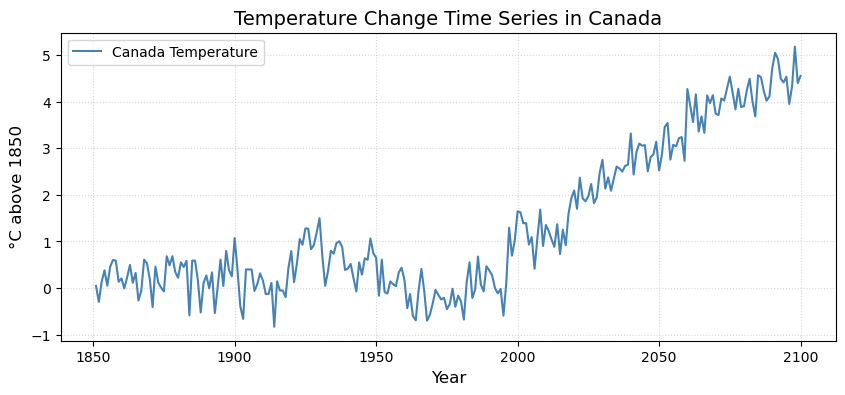

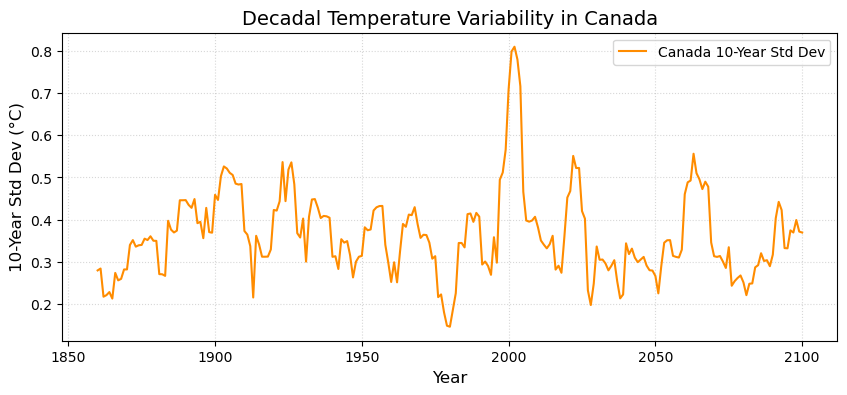

In [26]:
# YOUR CODE HERE
# 6a. Choose countries for detailed analysis
analysis_countries = ["Greenland", "Canada"]

# Loop over selected countries to produce visualizations
for country_name in analysis_countries:
    # Extract temperature time series for the country
    temp_series = country_df[country_name].values
    years = country_df["year"].values

    # --- Time Series Plot ---
    plt.figure(figsize=(10, 4))
    plt.plot(years, temp_series, label=f"{country_name} Temperature", color='steelblue')
    plt.title(f"Temperature Change Time Series in {country_name}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("°C above 1850", fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend()
    plt.show()

    # --- Decadal Variability Plot (10-year rolling standard deviation) ---
    decadal_std = pd.Series(temp_series).rolling(window=10, center=False).std()
    plt.figure(figsize=(10, 4))
    plt.plot(years, decadal_std, color='darkorange', label=f"{country_name} 10-Year Std Dev")
    plt.title(f"Decadal Temperature Variability in {country_name}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("10-Year Std Dev (°C)", fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend()
    plt.show()
# raise NotImplementedError()


# # YOUR CODE HERE
# # Countries to analyze
# countries = ["Greenland", "Canada"] 

# # --- Visualization 1: Time Series Plot for Greenland ---
# country = countries[0]
# y_analysis = country_df[country].values
# years_analysis = country_df["year"].values

# plt.figure(figsize=(10, 4))
# plt.plot(years_analysis, y_analysis, label=f'{country} Temp')
# plt.title(f"Temperature Change Time Series in {country}")
# plt.ylabel("°C above 1850")
# plt.xlabel("Year")
# plt.grid(True, linestyle=':', alpha=0.5)
# plt.show()

# # --- Visualization 2: Decadal Variability for Greenland ---
# decadal_variability = pd.Series(y_analysis).rolling(window=10, center=False).std()

# plt.figure(figsize=(10, 4))
# plt.plot(years_analysis, decadal_variability, color='orange', label=f'{country} 10-Year Std Dev')
# plt.title(f"Decadal Temperature Variability in {country}")
# plt.ylabel("10-Year Std Dev (°C)")
# plt.xlabel("Year")
# plt.legend()
# plt.grid(True, linestyle=':', alpha=0.5)
# plt.show()

# # --- Visualization 1: Time Series Plot for Canada ---
# country = countries[1]
# y_analysis = country_df[country].values

# plt.figure(figsize=(10, 4))
# plt.plot(years_analysis, y_analysis, label=f'{country} Temp')
# plt.title(f"Temperature Change Time Series in {country}")
# plt.ylabel("°C above 1850")
# plt.xlabel("Year")
# plt.grid(True, linestyle=':', alpha=0.5)
# plt.show()

# # --- Visualization 2: Decadal Variability for Canada ---
# decadal_variability = pd.Series(y_analysis).rolling(window=10, center=False).std()

# plt.figure(figsize=(10, 4))
# plt.plot(years_analysis, decadal_variability, color='orange', label=f'{country} 10-Year Std Dev')
# plt.title(f"Decadal Temperature Variability in {country}")
# plt.ylabel("10-Year Std Dev (°C)")
# plt.xlabel("Year")
# plt.legend()
# plt.grid(True, linestyle=':', alpha=0.5)
# plt.show()

# # raise NotImplementedError()

## 7. Make a command line interface to a prediction script 

The inputs should include the name of a country (or global mean) and cumulative CO2 emissions. It should return the predicted temperature change relative to 1850. You can use the `argparse` package to do this. See [here](https://docs.python.org/3/howto/argparse.html) for documentation. Be sure to check for valid inputs.

Also provide the option to save the predictions to a CSV file.

This script should use the regression coefficients learned in the previous step so it doesn't have to use the full model output each time. You could store them in a numpy file, a pandas CSV file, or even JSON. 

In [27]:
# --- 7. Prepare for CLI prediction ---

import pandas as pd
import os

# Path to the saved regression coefficients from previous analysis
coefs_file = "country_regression_coeffs.csv"

# Check that the coefficients file exists
if not os.path.exists(coefs_file):
    raise FileNotFoundError(
        f"Coefficient file '{coefs_file}' not found. "
        "Make sure you ran the regional regressions and saved the CSV."
    )

# Load the coefficients
coefs = pd.read_csv(coefs_file, index_col=0)

# Inspect the first few rows to ensure 'Global_Mean' or countries exist
print("--- Sample of Saved Regression Coefficients ---")
print(coefs.head())

# Optional: Check if 'Global_Mean' is included
if 'Global_Mean' not in coefs.index:
    print("Note: 'Global_Mean' is not in the coefficients file. "
          "You can add it using the global regression slope/intercept from part 3 if desired.")


--- Sample of Saved Regression Coefficients ---
               slope  intercept
country                        
Albania     0.000718  -0.320076
Algeria     0.000856  -0.147978
Angola      0.000677   0.073453
Antarctica  0.000436   0.122019
Argentina   0.000383   0.089030
Note: 'Global_Mean' is not in the coefficients file. You can add it using the global regression slope/intercept from part 3 if desired.


In [28]:
# YOUR CODE HERE
!python predict_temp.py Global_Mean 900.0 --save prediction_result.csv

# import argparse
# import pandas as pd
# import sys

# # Load the regression coefficients file
# coefs = pd.read_csv("country_regression_coeffs.csv", index_col=0)

# # CRITICAL CHECK: Ensure 'Global Mean' model is included for CLI generality.
# if 'Global Mean' not in coefs.index:
#     global_row_data = pd.DataFrame({
#         'slope': [global_slope],  # Replace with global_slope if it's defined in your notebook
#         'intercept': [global_intercept]  # Replace with global_intercept if it's defined in your notebook
#     }, index=['Global Mean'])
#     global_row_data.index.name = 'country'
#     coefs = pd.concat([coefs, global_row_data])
#     coefs.to_csv("country_regression_coeffs.csv")

# # Prediction function
# def predict_temperature(country: str, co2: float) -> float:
#     """
#     Predicts the temperature change (°C) for a given region (country or 'Global Mean')
#     based on the total cumulative CO2 emissions (GtC).
#     """
#     if country not in coefs.index:
#         available_regions = ', '.join(coefs.index.tolist()[:10]) + ', ...'
#         raise ValueError(f"Country or region '{country}' not found. Available options: {available_regions}")
    
#     slope = coefs.loc[country, "slope"]
#     intercept = coefs.loc[country, "intercept"]
    
#     return slope * co2 + intercept

# # CLI setup using argparse
# def main():
#     parser = argparse.ArgumentParser(description="Predict temperature change based on cumulative CO2 emissions.")
    
#     # Adding arguments
#     parser.add_argument('country', type=str, help="Country or 'Global Mean' for the prediction.")
#     parser.add_argument('co2', type=float, help="Cumulative CO2 emissions (GtC).")
#     parser.add_argument('--save', type=str, default=None, help="Optionally save the results to a CSV file.")
    
#     # Simulating command-line arguments for Jupyter (replace this with your own inputs)
#     # For example, let's say you want to predict for 'Global Mean' and 500 GtC
#     sys.argv = ['predict_temperature.py', 'Global Mean', '500']  # Simulate arguments

#     # Parsing arguments
#     args = parser.parse_args()

#     try:
#         # Predict the temperature change
#         predicted_temp = predict_temperature(args.country, args.co2)
#         print(f"Predicted temperature change for {args.country} at {args.co2} GtC: {predicted_temp:.3f} °C (above 1850 baseline)")

#         # Save the prediction to CSV if requested
#         if args.save:
#             result = pd.DataFrame({
#                 "country": [args.country],
#                 "cumulative_co2_gtc": [args.co2],
#                 "predicted_temp_c": [predicted_temp]
#             })
#             result.to_csv(args.save, index=False)
#             print(f"Prediction saved to {args.save}")

#     except ValueError as e:
#         print(f"Error: {e}")
#         sys.exit(1)

# if __name__ == '__main__':
#     main()

# raise NotImplementedError()


Error: Region 'Global_Mean' not found in coefficients file. Try one of: Albania, Algeria, Angola, Antarctica, Argentina, Armenia, Australia, Austria, Azerbaijan, Bangladesh, ...


In [29]:
import pandas as pd

# Load the coefficients file
coefs = pd.read_csv('country_regression_coeffs.csv', index_col=0)

# Check the first few rows to see if 'Global_Mean' exists
print(coefs.head())

               slope  intercept
country                        
Albania     0.000718  -0.320076
Algeria     0.000856  -0.147978
Angola      0.000677   0.073453
Antarctica  0.000436   0.122019
Argentina   0.000383   0.089030


In [30]:
import pandas as pd

# Load the coefficients
coefs = pd.read_csv('country_regression_coeffs.csv', index_col=0)

# Define global values (these should be computed in your notebook earlier)
global_slope = 0.0005  # Example value, replace with the actual value
global_intercept = 0.1  # Example value, replace with the actual value

# Add 'Global_Mean' to the coefficients DataFrame
global_row = pd.DataFrame({
    'slope': [global_slope],
    'intercept': [global_intercept]
}, index=['Global_Mean'])

# Concatenate it with the existing DataFrame
coefs = pd.concat([coefs, global_row])

# Save the updated coefficients back to the CSV
coefs.to_csv('country_regression_coeffs.csv')

print("Global_Mean added to country_regression_coeffs.csv")


Global_Mean added to country_regression_coeffs.csv


In [31]:
!python predict_temp.py Global_Mean 900.0 --save prediction_result.csv



--- Temperature Prediction Result ---
Region: Global_Mean
Cumulative CO2: 900.0 GtC
Predicted Warming: 0.550 °C (above 1850 baseline)

Prediction saved to prediction_result.csv


In [32]:
!python predict_temp.py India 900.0


--- Temperature Prediction Result ---
Region: India
Cumulative CO2: 900.0 GtC
Predicted Warming: 0.347 °C (above 1850 baseline)


In [33]:
import sys
sys.argv = ['predict_temp.py', 'India', '900.0', '--save', 'prediction_result.csv']

# Run your code to execute the prediction based on the simulated CLI arguments
!python predict_temp.py

usage: predict_temp.py [-h] [--save SAVE] region co2
predict_temp.py: error: the following arguments are required: region, co2


In [34]:
!python predict_temp.py Saudi_Arabia 500.0 --save prediction_result.csv


--- Temperature Prediction Result ---
Region: Saudi_Arabia
Cumulative CO2: 500.0 GtC
Predicted Warming: 0.412 °C (above 1850 baseline)

Prediction saved to prediction_result.csv


In [35]:
!python predict_temp.py Brazil 450.0 --save brazil_prediction.csv


--- Temperature Prediction Result ---
Region: Brazil
Cumulative CO2: 450.0 GtC
Predicted Warming: 0.329 °C (above 1850 baseline)

Prediction saved to brazil_prediction.csv


In [36]:
!python predict_temp.py Russia 1000.0


--- Temperature Prediction Result ---
Region: Russia
Cumulative CO2: 1000.0 GtC
Predicted Warming: 1.117 °C (above 1850 baseline)


In [37]:
!python predict_temp.py India 900.0 --save prediction_result.csv
!python predict_temp.py Saudi_Arabia 500.0 --save prediction_result.csv
!python predict_temp.py Canada 700.0 --save canada_result.csv
!python predict_temp.py Russia 1200.0 --save russia_result.csv


--- Temperature Prediction Result ---
Region: India
Cumulative CO2: 900.0 GtC
Predicted Warming: 0.347 °C (above 1850 baseline)

Prediction saved to prediction_result.csv

--- Temperature Prediction Result ---
Region: Saudi_Arabia
Cumulative CO2: 500.0 GtC
Predicted Warming: 0.412 °C (above 1850 baseline)

Prediction saved to prediction_result.csv

--- Temperature Prediction Result ---
Region: Canada
Cumulative CO2: 700.0 GtC
Predicted Warming: 0.744 °C (above 1850 baseline)

Prediction saved to canada_result.csv

--- Temperature Prediction Result ---
Region: Russia
Cumulative CO2: 1200.0 GtC
Predicted Warming: 1.307 °C (above 1850 baseline)

Prediction saved to russia_result.csv


In [38]:
import pandas as pd

# Load the prediction CSV files
prediction_df = pd.read_csv('prediction_result.csv')
canada_df = pd.read_csv('canada_result.csv')
russia_df = pd.read_csv('russia_result.csv')

# Display the DataFrames
print("India Prediction Result:")
print(prediction_df)

print("\nCanada Prediction Result:")
print(canada_df)

print("\nRussia Prediction Result:")
print(russia_df)

India Prediction Result:
         region  cumulative_co2_gtc  predicted_temp_c
0  Saudi_Arabia               500.0          0.412393

Canada Prediction Result:
   region  cumulative_co2_gtc  predicted_temp_c
0  Canada               700.0          0.743927

Russia Prediction Result:
   region  cumulative_co2_gtc  predicted_temp_c
0  Russia              1200.0          1.307205


In [39]:
# pip install pycodestyle

In [40]:
# !pip install flake8 autopep8

In [41]:
# !flake8 --max-line-length=120 Finalproject.ipynb

In [42]:
# !python -m flake8 predict_temp.py

In [43]:
# !python -m flake8 Finalproject.ipynb

---
### No action is required below. Your answers for the project should be written **above this line only**.  
*(Do **not** modify or delete the following “YOUR ANSWER HERE” block.)*

You may see a block below that says **"YOUR ANSWER HERE"**. This block is **not for you to fill in** — it is used internally by the TAs to grade the documentation, coding style, and code quality portions of your project.

- Documentation and Explanation — 10 points  
- Code Documentation & Style — 5 points  
- Code Organization & Structure — 5 points  


YOUR ANSWER HERE

YOUR ANSWER HERE

YOUR ANSWER HERE